# Vectorizing and Preparing for Training

Date: 01/30/2021

## About this Notebook
This is developing the train and test data for the model

## Adminstrative Activity

### Import Packages

In [1]:
import os, json, sys
from packaging import version

import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

import re, string #Text cleaning

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN,RNN, LSTM
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense

from sklearn.model_selection import train_test_split #train_test_split

#Custom Code
from bin.text_cleaner import text_cleaner
from bin.html_functions import ez_display as d
from bin.plot_performance_graph import plot_performance
from bin.run_model import run_model

### Python Version

In [2]:
d("<b>Current Python Version Used:</b> Python " +  sys.version.split('(')[0].strip())
d("This notebook requires TensorFlow 2.0 or above")
d("<b>Current TensorFlow version: </b>"+ tf.__version__)
d("<b>Current Keras version: </b>"+ keras.__version__)
assert version.parse(tf.__version__).release[0] >=2

### Establish Experiment Reproducibility

In [3]:
keras.backend.clear_session()
np.random.seed(45)
tf.random.set_seed(45)

### Variables

In [4]:
data_folder = "data"
raw_data_folder = os.path.join(data_folder,'RAW')
images_folder = "images"
model_summary_folder = os.path.join(images_folder,"model_summary")
model_folder = "models"
graph_folder = os.path.join(images_folder,"graphs")
word_freq_folder = os.path.join(data_folder,"word_frequency")
padded_folder = os.path.join(data_folder,"padded")
padded_train_folder = os.path.join(padded_folder,'train')
padded_test_folder = os.path.join(padded_folder,'test')
cleaned_data_folder = os.path.join(data_folder,'cleaned')
cleaned_data_filename = "articles.feather"
cleaned_data_filepath = os.path.join(cleaned_data_folder,cleaned_data_filename)
article_filenames = ['articles1.csv', 'articles2.csv', 'articles3.csv']
publication_scorecard_filename = "publication_scorecard.json"
publication_scorecard_filepath = os.path.join(data_folder,publication_scorecard_filename)
text_cols = ['content','simple_clean','stopwords_clean','lemming_clean']
padding = { 'content': 700,
            'simple_clean': 350,
            'stopwords_clean': 350,
            'lemming_clean': 350}

In [5]:
if os.path.isdir(model_folder) == False:
    os.mkdir(model_folder)
if os.path.isdir(model_summary_folder) == False:
    os.mkdir(model_summary_folder)

## Pulling Data

In [6]:
padded_files = {}
padded_files['train'] = os.listdir(padded_train_folder)
padded_files['test'] = os.listdir(padded_test_folder)

In [7]:
padded_file_to_use = 'stopwords_clean'

In [8]:
x = {}
y = {}
for k,v in padded_files.items():
    file = [file for file in v if file.find(padded_file_to_use) != -1][0]
    if k == 'train':
        prefix = padded_train_folder
    if k == 'test':
        prefix = padded_test_folder
    filepath = os.path.join(prefix,file)
    with open(filepath,'rb') as f:
        x[k] = np.load(f) # Vectorized Articles
        y[k] = np.load(f) # The political spectrum value

### Verifying load

In [9]:
for k,v in x.items():
    print(f'x {k} shape:{v.shape}')
for k,v in y.items():
    print(f'y {k} shape:{v.shape}')

x train shape:(113969, 350)
x test shape:(28493, 350)
y train shape:(113969,)
y test shape:(28493,)


## Build Transformer Model
https://keras.io/examples/nlp/text_classification_with_transformer/

In [10]:
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            key, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(
            concat_attention
        )  # (batch_size, seq_len, embed_dim)
        return output

In [11]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [12]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [22]:
embed_dim = 64  # Embedding size for each token
num_heads = 4  # Number of attention heads
ff_dim = 64  # Hidden layer size in feed forward network inside transformer
input_length = len(x['train'][0])
vocab_size = 200001
model_name = "Stopwords_Clean_Transformer"

## Building Model (Regression)
Look into using RMSE instead of MSE

In [29]:
inputs = layers.Input(shape= (input_length,))
embedding_layer = TokenAndPositionEmbedding(input_length, vocab_size, embed_dim)
model = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
model = transformer_block(model)
model = layers.GlobalAveragePooling1D()(model)
model = layers.Dropout(0.2)(model)
model = layers.Dense(20, activation = "tanh")(model)
model = layers.Dropout(0.2)(model)
outputs = layers.Dense(1, activation = "tanh")(model) # Review
transformer = keras.Model(inputs=inputs, outputs=outputs, name=model_name)
transformer.compile(optimizer = 'adam',
                    loss = 'mean_squared_error',
                    metrics  = [tf.keras.metrics.MeanSquaredError()])

## visualize model

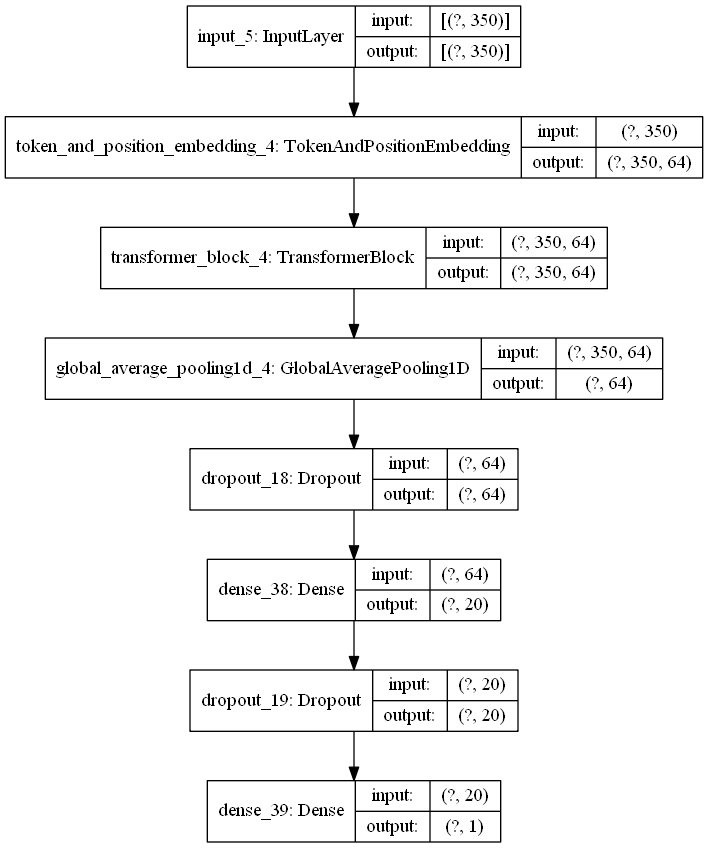

In [30]:
model_summary_filepath = os.path.join(model_summary_folder,model_name+".png")
keras.utils.plot_model(transformer,model_summary_filepath,show_shapes=True)

In [31]:
compiled_model, model_history = run_model(transformer,
                                          model_name = model_name,
                                          x = x,y = y,
                                          epochs=3)

Epoch 1/3
757/757 [==============================] - 65s 86ms/step - loss: 0.2490 - mean_squared_error: 0.2490 - val_loss: 0.1807 - val_mean_squared_error: 0.1807
Epoch 2/3
757/757 [==============================] - 64s 85ms/step - loss: 0.1345 - mean_squared_error: 0.1345 - val_loss: 0.1588 - val_mean_squared_error: 0.1588
Epoch 3/3
757/757 [==============================] - 64s 85ms/step - loss: 0.0909 - mean_squared_error: 0.0909 - val_loss: 0.1689 - val_mean_squared_error: 0.1689
Total Train Time: 0:03:15.264221


891/891 [==============================] - 5s 6ms/step - loss: 0.1723 - mean_squared_error: 0.1723
test set accuracy:  17.228080332279205


In [32]:
model_filepath = os.path.join(model_folder,model_name)
compiled_model.save(model_filepath)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models\Stopwords_Clean_Transformer\assets


## Build Model (Categorical)

In [ ]:
inputs = layers.Input(shape= (input_length,))
embedding_layer = TokenAndPositionEmbedding(input_length, vocab_size, embed_dim)
model = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
model = transformer_block(model)
model = layers.GlobalAveragePooling1D()(model)
model = layers.Dropout(0.2)(model)
model = layers.Dense(20, activation = "tanh")(model)
model = layers.Dropout(0.2)(model)
outputs = layers.Dense(1, activation = "tanh")(model) # Review
transformer = keras.Model(inputs=inputs, outputs=outputs, name=model_name)
transformer.compile(optimizer = 'adam',
                    loss = 'mean_squared_error',
                    metrics  = ['accuracy'])

### Performance Metrics

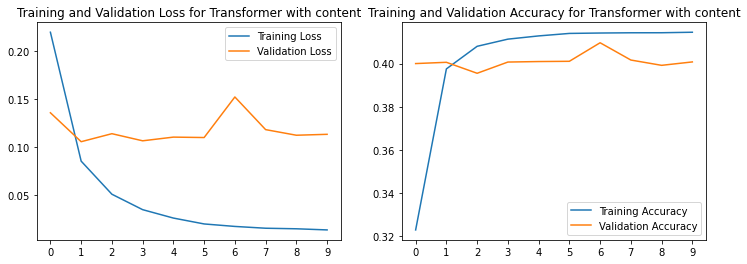

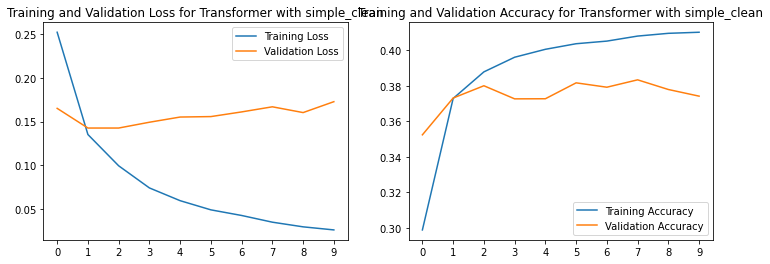

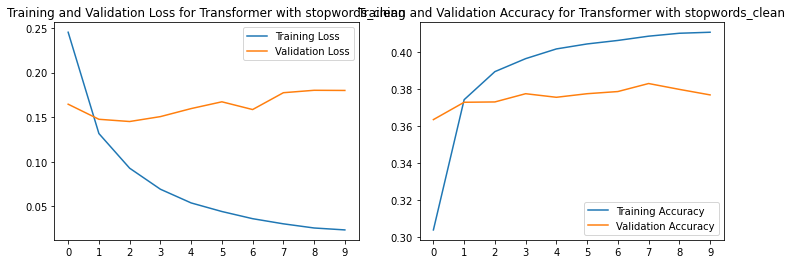

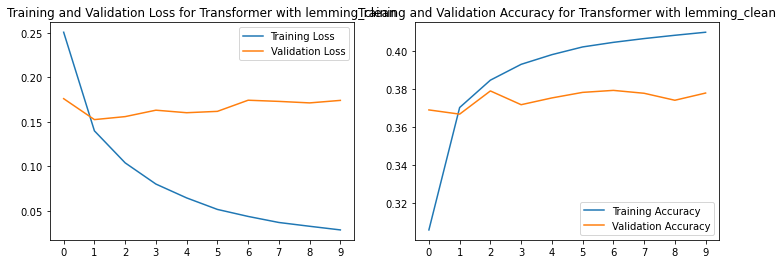

In [109]:
for col in text_cols:
    model_name = "Transformer"
    plot_name = f'{model_name} with {col}'
    history = run_results[col][model_name][col]['history']
    plot_performance(history,plot_name,images_folder)